<a href="https://colab.research.google.com/github/JDS289/BaLD4LLM/blob/main/playingAround.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using GPU seems to sometimes cause a CUDA error; using TPU seems to sometimes cause "Unknown crash".
CPU takes approximately 10x longer than GPU.


3B has said False to "Paris is the capital of France". Might want to use 8B instead. For now, I'll continue to use 3B for speed/simplicity. This is also justified for "reproducibility" reasons, though if accuracy is negligible then switch to a better model.

8B works with TPU? (sample size 1)
but still insanely slow - hasn't yet answered a single prompt (i think it may have gotten one or two, but i don't remember)

AHH it turns out 3B is good with low temperature.

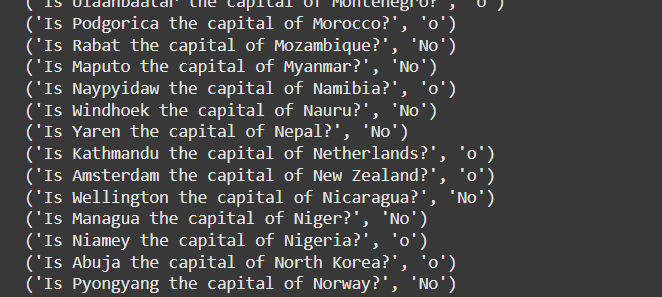

In [ ]:
# Not sure why it's saying 'o'.  Maybe I limited generation-length too much or something?

In [ ]:
from google.colab import userdata
hf_token = userdata.get("huggingface_secret")

from huggingface_hub import login
login(token=hf_token)

In [ ]:
DEFAULT_MODEL = ["meta-llama/Llama-3.1-8B-Instruct", "meta-llama/Llama-3.2-3B-Instruct"][1]

from typing import Optional
import os
import torch
from accelerate import Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
from tqdm.notebook import tqdm



device = "cuda" if torch.cuda.is_available() else "cpu"
#import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


SYS_PROMPT = "" # experiment with this?


accelerator = Accelerator()

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    torch_dtype=torch.bfloat16,
    use_safetensors=True,
    device_map="auto",
    output_hidden_states=True,
    return_dict_in_generate=True,
)

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_safetensors=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
model, tokenizer = accelerator.prepare(model, tokenizer)

model.generation_config.pad_token_id = tokenizer.pad_token_id
model.generation_config.output_hidden_states = True
model.generation_config.return_dict_in_generate = True

In [ ]:
def process_chunk(text_chunk_batch):
    if type(text_chunk_batch) == str:
        text_chunk_batch = [text_chunk_batch]

    assert len(text_chunk_batch) == 1
    # Haven't fully integrated batching yet, should be done soon


    conversations = [[
        {"role": "system", "content": SYS_PROMPT},
        {"role": "user", "content": text_chunk}]
              for text_chunk in text_chunk_batch]

    # remove [0] in the below line to facilitate batching
    prompt = tokenizer.apply_chat_template(conversations[0], tokenize=False)
    inputs = tokenizer(prompt, padding="max_length", padding_side="left", max_length=64, return_tensors="pt")
    inputs = inputs.to(accelerator.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            temperature=0.01,
            top_p=0.9,
            max_new_tokens=5
        )
    # For answering yes/no questions like the following, extremely low temperature and max_new_tokens makes sense.
    # For this actual task its generations are not actually relevant, but they're helpful to see and might be useful later.

    processed_texts = tokenizer.batch_decode(output.sequences, skip_special_tokens=True)
    processed_texts = [text[text.index("assistant") + 10:].lstrip() for text in processed_texts]

    # remove [0] in the below line to facilitate batching
    return processed_texts[0], output.hidden_states

38


In [ ]:
import requests

capitals = requests.get("https://raw.githubusercontent.com/JDS289/BaLD4LLM/refs/heads/main/country-list.csv")
capitals_dict = {}
for string in capitals.content.decode('utf-8').split('\n')[1 : -1]:
  _, country, _, city, _ = string.split('"')
  capitals_dict[country] = city

print(capitals_dict)

{'Afghanistan': 'Kabul', 'Albania': 'Tirana', 'Algeria': 'Algiers', 'Andorra': 'Andorra la Vella', 'Angola': 'Luanda', 'Antigua and Barbuda': "St. John's", 'Argentina': 'Buenos Aires', 'Armenia': 'Yerevan', 'Australia': 'Canberra', 'Austria': 'Vienna', 'Azerbaijan': 'Baku', 'Bahamas': 'Nassau', 'Bahrain': 'Manama', 'Bangladesh': 'Dhaka', 'Barbados': 'Bridgetown', 'Belarus': 'Minsk', 'Belgium': 'Brussels', 'Belize': 'Belmopan', 'Benin': 'Porto-Novo', 'Bhutan': 'Thimphu', 'Bosnia and Herzegovina': 'Sarajevo', 'Botswana': 'Gaborone', 'Brazil': 'Brasília', 'Brunei': 'Bandar Seri Begawan', 'Bulgaria': 'Sofia', 'Burkina Faso': 'Ouagadougou', 'Burundi': 'Bujumbura', 'Cambodia': 'Phnom Penh', 'Cameroon': 'Yaoundé', 'Canada': 'Ottawa', 'Cape Verde': 'Praia', 'Central African Republic': 'Bangui', 'Chad': "N'Djamena", 'Chile': 'Santiago', 'China': 'Beijing', 'Colombia': 'Bogotá', 'Comoros': 'Moroni', 'Costa Rica': 'San José', 'Croatia': 'Zagreb', 'Cuba': 'Havana', 'Cyprus': 'Nicosia', "Côte d'Ivo

In [ ]:
MODE = "statements"

if MODE == "statements":
  true_list = [f"{capital} is the capital of {country}." for country, capital in capitals_dict.items()]
  fixed_order_capitals_dict = list(capitals_dict.items())
  false_list = [f"{fixed_order_capitals_dict[i][1]} is the capital of {fixed_order_capitals_dict[(i+1) % len(capitals_dict)][0]}." for i in range(len(capitals_dict))]

  results_true = [(q,) + process_chunk(q) for q in tqdm(true_list)]
  results_false = [(q,) + process_chunk(q) for q in tqdm(false_list)]

elif MODE == "questions":
  true_list = [f"Is {capital} the capital of {country}?" for country, capital in capitals_dict.items()]
  fixed_order_capitals_dict = list(capitals_dict.items())
  # Consider re-adding "(Yes/No)"   (if the generated answers actually matter at all, that is)
  false_list = [f"Is {fixed_order_capitals_dict[i][1]} is the capital of {fixed_order_capitals_dict[(i+1) % len(capitals_dict)][0]}?" for i in range(len(capitals_dict))]

  def print_return(triple):
    print(triple[:2])
    return triple

  results_true = [print_return((q,) + process_chunk(q)) for q in tqdm(true_list)]
  results_false = [print_return((q,) + process_chunk(q)) for q in tqdm(false_list)]

['Is Kabul the capital of Afghanistan?', 'Is Tirana the capital of Albania?', 'Is Algiers the capital of Algeria?', 'Is Andorra la Vella the capital of Andorra?', 'Is Luanda the capital of Angola?', "Is St. John's the capital of Antigua and Barbuda?", 'Is Buenos Aires the capital of Argentina?', 'Is Yerevan the capital of Armenia?', 'Is Canberra the capital of Australia?', 'Is Vienna the capital of Austria?'] ['Is Kabul the capital of Albania?', 'Is Tirana the capital of Algeria?', 'Is Algiers the capital of Andorra?', 'Is Andorra la Vella the capital of Angola?', 'Is Luanda the capital of Antigua and Barbuda?', "Is St. John's the capital of Argentina?", 'Is Buenos Aires the capital of Armenia?', 'Is Yerevan the capital of Australia?', 'Is Canberra the capital of Austria?', 'Is Vienna the capital of Azerbaijan?']


  0%|          | 0/187 [00:00<?, ?it/s]

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


('Is Kabul the capital of Afghanistan?', 'Yes')
('Is Tirana the capital of Albania?', 'Yes')
('Is Algiers the capital of Algeria?', 'Yes')
('Is Andorra la Vella the capital of Andorra?', 'Yes')
('Is Luanda the capital of Angola?', 'Yes')
("Is St. John's the capital of Antigua and Barbuda?", 'No')
('Is Buenos Aires the capital of Argentina?', 'Yes')
('Is Yerevan the capital of Armenia?', 'Yes')
('Is Canberra the capital of Australia?', 'Yes')
('Is Vienna the capital of Austria?', 'Yes')
('Is Baku the capital of Azerbaijan?', 'Yes')
('Is Nassau the capital of Bahamas?', 'Yes')
('Is Manama the capital of Bahrain?', 'Yes')
('Is Dhaka the capital of Bangladesh?', 'Yes')
('Is Bridgetown the capital of Barbados?', 'Yes')
('Is Minsk the capital of Belarus?', 'Yes')
('Is Brussels the capital of Belgium?', 'Yes')
('Is Belmopan the capital of Belize?', 'No')
('Is Porto-Novo the capital of Benin?', 'No')
('Is Thimphu the capital of Bhutan?', 'Yes')
('Is Sarajevo the capital of Bosnia and Herzegovi

  0%|          | 0/187 [00:00<?, ?it/s]

('Is Kabul the capital of Albania?', 'o')
('Is Tirana the capital of Algeria?', 'o')
('Is Algiers the capital of Andorra?', 'No')
('Is Andorra la Vella the capital of Angola?', 'o')
('Is Luanda the capital of Antigua and Barbuda?', 'No')
("Is St. John's the capital of Argentina?", 'No')
('Is Buenos Aires the capital of Armenia?', 'o')
('Is Yerevan the capital of Australia?', 'No')
('Is Canberra the capital of Austria?', 'No')
('Is Vienna the capital of Azerbaijan?', 'No')
('Is Baku the capital of Bahamas?', 'No')
('Is Nassau the capital of Bahrain?', 'Yes')
('Is Manama the capital of Bangladesh?', 'No')
('Is Dhaka the capital of Barbados?', 'o')
('Is Bridgetown the capital of Belarus?', 'No')
('Is Minsk the capital of Belgium?', 'No')
('Is Brussels the capital of Belize?', 'No')
('Is Belmopan the capital of Benin?', 'o')
('Is Porto-Novo the capital of Bhutan?', 'No')
('Is Thimphu the capital of Bosnia and Herzegovina?', 'o')
('Is Sarajevo the capital of Botswana?', 'o')
('Is Gaborone t

In [ ]:
want_to_do_this = False

if want_to_do_this:
  statements = []
  responses = []
  hidden_statess = []
  statements_false = []
  responses_false = []
  hidden_statess_false = []


  for s, r, h in results:
    statements.append(s)
    responses.append(r)
    hidden_statess.append(h)


  for s, r, h in results_false:
    statements_false.append(s)
    responses_false.append(r)
    hidden_statess_false.append(h)

In [ ]:
# 5 * 29 * 1 * (39 if first-dim = 0 else 1) * 3072  for EACH hidden_statess[i]

# according to https://huggingface.co/docs/transformers/v4.47.0/en/internal/generation_utils#generate-outputs,
# this is probably 5 tokens-generated * 29 layers * 1 batch * (39 | 1) "generated length"   *  3072 activations


# okay yeah 5 is the number of tokens in a typical response, like "<thingyID>assistant\n\nYes"
# prompt has 38 tokens i think, so basically 39?

In [ ]:
import pickle

with open("/content/drive/My Drive/hidden_statess/true_hidden_statess.pkl", "rb") as f:
  true_hidden_statess = pickle.load(f)

with open("/content/drive/My Drive/hidden_statess/false_hidden_statess.pkl", "rb") as f:
  false_hidden_statess = pickle.load(f)

In [ ]:
between_class_distances = []  # one for each layer
within_class_distances = []  # averaged between True and False; so one for each layer
between_within_ratios = []

for layer_i in range(len(true_hidden_statess[0][0])):
  current_true_average = sum(hidden_states[0][layer_i][0][-1] for hidden_states in true_hidden_statess) / len(true_hidden_statess)
  average_true_distance = sum(torch.norm(current_true_average - hidden_states[0][layer_i][0][-1]) for hidden_states in true_hidden_statess) / len(true_hidden_statess)

  current_false_average = sum(hidden_states[0][layer_i][0][-1] for hidden_states in false_hidden_statess) / len(false_hidden_statess)
  average_false_distance = sum(torch.norm(current_false_average - hidden_states[0][layer_i][0][-1]) for hidden_states in false_hidden_statess) / len(false_hidden_statess)

  between_class_distances.append(torch.norm(current_true_average - current_false_average))
  within_class_distances.append((average_true_distance + average_false_distance) / 2)

  between_within_ratios.append((between_class_distances[-1] / within_class_distances[-1]).item())


Text(0.5, 1.0, 'True-False Separation by Layer')

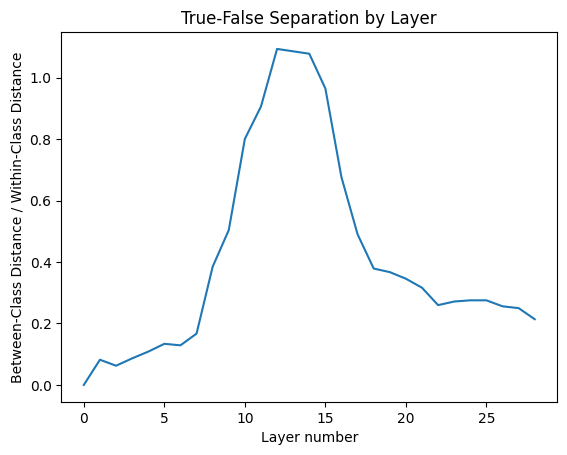

In [ ]:
from matplotlib import pyplot as plt

plt.plot(between_within_ratios)

plt.xlabel("Layer number")
plt.ylabel("Between-Class Distance / Within-Class Distance")
plt.title("True-False Separation by Layer")

The "Classes" here are simply {true_statements, false_statements}.

We are using the residual stream activations ($\textbf{r} \in \mathbb{R}^{3072} $) over the final token in input.

Letting $A(s)$ be the activation vector over the final token in input statement $s$, we have, for a layer $l$:


$$\text{trues_center}(l) = \frac{\displaystyle\sum_{s \in \text{true_statements}} {A(s)} }{|\text{true_statements}|} \qquad \qquad \qquad \qquad \quad \text{trues_mean_dist}(l) = \frac{\displaystyle\sum_{s \in \text{true_statements}} {|A(s) - \text{trues_center}(l)|} }{|\text{true_statements}|} \\[0.5in] \text{falses_center}(l) = \frac{\displaystyle\sum_{s \in \text{false_statements}} {A(s)} }{|\text{false_statements}|} \qquad \qquad \qquad \qquad \quad \text{falses_mean_dist}(l) = \frac{\displaystyle\sum_{s \in \text{false_statements}} {|A(s) - \text{falses_center}(l)|} }{|\text{false_statements}|}
\\[0.5in] {\scriptstyle\text{between_class_distance}}(l)=|\text{trues_center}(l)-\text{falses_center}(l)| \qquad  \text{within_class_distance}(l) = \frac{\scriptstyle\text{ trues_mean_dist}+\text{falses_mean_dist}}{2} $$



In [ ]:
import pickle

with open("/content/drive/My Drive/hidden_statess/true_relevant_states.pkl", "rb") as f:
  true_relevant_states = pickle.load(f)

with open("/content/drive/My Drive/hidden_statess/false_relevant_states.pkl", "rb") as f:
  false_relevant_states = pickle.load(f)